# Pytorch
Ejemplo de clasificador con Pytorch, comentado en español. 

El cuaderno de Jupyter se ha desarrollado con Visual Code y puedes encontrar el código en https://github.com/josegemez/pytorch_mnist 

Se ha desarrollado en python 3.10.4 

## Import
Con las primeras lineas vamos a importar los paquetes que básicos de Pytorch. 

In [95]:
import torch
import torchvision

## Variables Generales

In [115]:
batch_size_train = 128

## Transformaciones 

In [116]:
transforms=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Normalize((0.1307,), (0.3081,))
                            ])

## Dataset Entrenamiento

In [117]:
dataset_mnist = torchvision.datasets.MNIST('/files/', train=True, download=True, transform=transforms)                    

## Dataloader

In [118]:
train_loader = torch.utils.data.DataLoader(dataset_mnist,  batch_size=batch_size_train, shuffle=True)

Vamos a ver que "pinta" tiene cada elemento del cargador

In [119]:
x, y = next(iter(train_loader)) #asignamos el primer batch a las variables x e y. La variable X contrendra las imagenes e y contrendra las etiquetas

In [120]:
x.shape

torch.Size([128, 1, 28, 28])

x es un batch, por lo que la primera dimensión coincidira con el batch size 

In [121]:
from matplotlib.pyplot import imshow

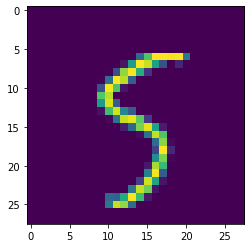

In [122]:
imshow(x[0].view(28,28).numpy()); # transformamos el primer elemento del batch una matriz de numpy y mostramos con matplotlib

In [123]:
y

tensor([5, 3, 5, 5, 3, 0, 7, 0, 5, 9, 0, 0, 7, 8, 0, 3, 9, 1, 9, 7, 1, 2, 3, 9,
        1, 3, 5, 1, 4, 1, 5, 4, 5, 6, 2, 8, 0, 4, 5, 1, 5, 9, 7, 2, 7, 9, 5, 2,
        2, 1, 8, 4, 3, 2, 7, 7, 0, 4, 6, 6, 5, 4, 3, 0, 9, 9, 4, 4, 8, 4, 3, 4,
        1, 8, 4, 5, 6, 0, 4, 4, 5, 5, 3, 4, 9, 9, 8, 9, 1, 4, 6, 4, 2, 3, 4, 5,
        6, 1, 7, 8, 0, 8, 2, 3, 6, 8, 3, 6, 9, 8, 4, 9, 2, 0, 6, 4, 4, 7, 9, 6,
        2, 3, 7, 1, 9, 2, 4, 1])

## Dataset Test

In [124]:
dataset_mnist_test = torchvision.datasets.MNIST('/files/', train=False, download=True, transform=transforms)  # Train ahora se pone en False    
test_loader = torch.utils.data.DataLoader(dataset_mnist,  batch_size=batch_size_train, shuffle=True)              

Ya tenemos los datos preparados, ahora vamos a crear la red

In [125]:
learning_rate   =   0.01
momentum   =   0.5
n_epochs = 5
log_interval   =   10

In [126]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [127]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) 
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [128]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum)

In [129]:
model

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [130]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [131]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda')
device

device(type='cuda')

In [132]:
def train(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device=device), target.to(device=device)
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(model.state_dict(), 'results/model.pth')
      torch.save(optimizer.state_dict(), 'results/optimizer.pth')

In [136]:
def test():
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device=device), target.to(device=device)
      output = model(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [137]:
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

C:\Users\jose\AppData\Local\Temp\ipykernel_22864\746712537.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 0.404212
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.291219
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.225978
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.360579
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.293713
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.460779
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.208715
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.253121
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.270561
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.338272
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.214927
Train Epoch: 1 [14080/60000 (23%)]	Loss: 0.171565
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.300624
Train Epoch: 1 [16640/60000 (28%)]	Loss: 0.357604
Train Epoch: 1 [17920/60000 (30%)]	Loss: 0.283089
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.198476
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.159070
Train Epoch: 1 [21760/60000 (36%)]	Loss: 0.293819
Train Epoch: 1 [23040/60000 (38%)]	Loss: 0.227059
Train Epoch: 1 [24320/60000 (41%)]	Loss: 0.235513
Train Epoch: 1 [

c:\Users\jose\anaconda3\envs\pytorch\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1015, Accuracy: 58140/60000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.290193
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.296355
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.289227
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.232863
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.255078
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.270220
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.284517
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.293392
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.232994
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.279123
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.225431
Train Epoch: 2 [14080/60000 (23%)]	Loss: 0.239266
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.296275
Train Epoch: 2 [16640/60000 (28%)]	Loss: 0.272007
Train Epoch: 2 [17920/60000 (30%)]	Loss: 0.167046
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.329694
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.221038
Train Epoch: 2 [21760/60000 (36%)]	Loss: 0.198694
Train Epoch: 2 [23040/60000 (38%)]	Loss: 0.294684
Train E

In [138]:
import matplotlib.pyplot as plt

ValueError: x and y must be the same size

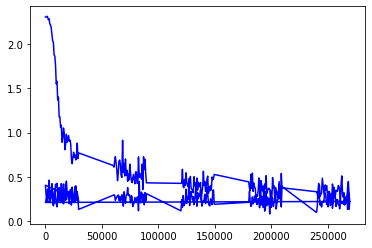

In [139]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig